In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!curl -q https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#!python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev
!pip -q install seqeval


In [3]:
import torch
torch.__version__

'1.10.0+cu111'

In [4]:
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import json
from collections import defaultdict, OrderedDict
import math
import numpy as np
import random
from sklearn.metrics import confusion_matrix

torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

In [5]:
!pip install transformers

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForTokenClassification, BertTokenizer, BertConfig, BertModel

## Initialize GPU

In [7]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dev

device(type='cuda', index=0)

## Load data

In [8]:
# Read export file
with open('/content/drive/MyDrive/ML_Models/Bi-LSTM/doccano_output.jsonl', 'r') as f:
    lines = f.readlines()

print(json.loads(lines[30]))

{'id': 11178, 'data': 'In 2020, we launched two new Workshop-wide task forces.2 Weve never had anything like this, says Rosemarie Truglio, SVP of curriculum and content. These efforts will affect everyones work, growth, and development.', 'label': [[116, 120, 'B-POS'], [114, 116, 'O'], [107, 114, 'I-PER'], [97, 107, 'B-PER'], [0, 3, 'O'], [3, 7, 'O'], [7, 9, 'O'], [9, 12, 'O'], [12, 21, 'O'], [21, 25, 'O'], [25, 29, 'O'], [29, 42, 'O'], [43, 48, 'O'], [48, 54, 'O'], [55, 57, 'O'], [54, 55, 'O'], [57, 62, 'O'], [62, 68, 'O'], [68, 72, 'O'], [72, 81, 'O'], [81, 86, 'O'], [86, 90, 'O'], [90, 92, 'O'], [92, 97, 'O'], [120, 123, 'I-POS'], [123, 134, 'I-POS'], [134, 138, 'I-POS'], [138, 145, 'I-POS'], [145, 147, 'O'], [147, 153, 'O'], [153, 161, 'O'], [161, 166, 'O'], [166, 173, 'O'], [173, 183, 'O'], [183, 187, 'O'], [187, 189, 'O'], [189, 195, 'O'], [195, 197, 'O'], [197, 201, 'O'], [201, 212, 'O'], [212, 213, 'O']]}


### Read in from JSON

In [9]:
# The numerical doccano label to actual label (B-I-O scheme)

ix_to_label = {1: 'B-PER', 2: 'I-PER', 3:'B-POS', 4:'I-POS', 5:'B-ORG', 6: 'I-ORG', 7: 'O'}
    
# train/test data
data = []

# Vocabulary
vocab = set()
    
# Loop over each data point (a corpus of labeled text) to extract words
for line in lines:

    # An ordered dict will keep items in order for further manipulation
    # so we initialize here
    orddict = OrderedDict({})

    # Lists to hold the words and labels
    words = []
    labels = []
    # Convert line to json
    input_json = json.loads(line)
    annots = input_json['label']
    text = input_json['data']
    
    # Add each word annotation to OrderedDict
    for ann in annots:
        orddict[ann[0]] = ann
    
    # Sort ordered dict
    # maintained order
    orddict = sorted(orddict.items(), key=lambda x: x[1][0])
    
    for item in orddict:
        # the item is a tuple where second value is the actual value we want
        ann = item[1]
        # Subset text string
        word = text[ann[0]:(ann[1])].rstrip()
        label = ann[2]
        # Add to list for this datum/corpus
        words.append(word)
        labels.append(label)
        vocab.add(word)
    # Add to overall data containers
    data.append((words, labels))

In [10]:
slens = [len(data[i][0]) for i in range(len(data))]
max(slens)

200

## Reassemble sentences and tag-mappings



In [11]:
ix_to_label = {0: 'B-PER', 1: 'I-PER', 2:'B-POS', 3:'I-POS', 4:'B-ORG', 5: 'I-ORG', 6: 'O'}
tags_vals = [v for k,v in ix_to_label.items()]
tag2idx = {t: i for i, t in ix_to_label.items()}
sentences = [' '.join([s for s in sent[0]]) for sent in data]
labels = [[s for s in sent[1]] for sent in data]
labels = [[tag2idx.get(l) for l in lab] for lab in labels]
print(tag2idx)

{'B-PER': 0, 'I-PER': 1, 'B-POS': 2, 'I-POS': 3, 'B-ORG': 4, 'I-ORG': 5, 'O': 6}


## BERT-BASE-CASED

Before we can begin fine-tuning our model, we have to establish a few environment variables and hyper parameters that we will be using in our model and use a few of these to create a `CustomDataset` that can be used by the models in the HuggingFace library. 

A principle component of this dataset is the tokenizer that we will be using, as the embeddings of the tokenizer have to match the embeddings expected by the model. In this case we will be using `bert-base-cased` to tokenize and extract entities from our input sentences.


In [12]:
# Defining some key variables that will be used later on in the training
MAX_LEN = max(slens)
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

### Assemble Data-loader

In addition to the tokenizer above, the other essential components of our `CustomDataset` are the input sentences themselves, their labels, and the lengths of each sequence (as well as the max_sequence length, which we will use to pad the shorter sequences). Additionally, as part of the requirements for evaluating sequences in the transformer architecture, the tokenizer we provided also outputs the `attention_mask` for each sequence that will be used during training.



In [13]:
class CustomDataset(Dataset):
    def __init__(self, tokenizer, sentences, labels, max_len):
        self.len = len(sentences)
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        sentence = str(self.sentences[index])
        inputs = self.tokenizer.encode_plus(
            sentence,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length = True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        label = self.labels[index]
        label.extend([6]*MAX_LEN)
        label=label[:MAX_LEN]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'tags': torch.tensor(label, dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

### Train/test splitting

In [14]:
train_percent = 0.8
train_size = int(train_percent*len(sentences))
# train_dataset=df.sample(frac=train_size,random_state=200).reset_index(drop=True)
# test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_sentences = sentences[0:train_size]
train_labels = labels[0:train_size]

test_sentences = sentences[train_size:]
test_labels = labels[train_size:]
print(labels[1])
print("FULL Dataset: {}".format(len(sentences)))
print("TRAIN Dataset: {}".format(len(train_sentences)))
print("TEST Dataset: {}".format(len(test_sentences)))

training_set = CustomDataset(tokenizer, train_sentences, train_labels, MAX_LEN)
testing_set = CustomDataset(tokenizer, test_sentences, test_labels, MAX_LEN)

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 4, 6]
FULL Dataset: 108
TRAIN Dataset: 86
TEST Dataset: 22


AUTHOR NOTE: As we can see from above, we do not have a lot of observations for fine-tuning the model, this is also the case for the BiLSTM-CRF that we train in a separate notebook, so for comparisons sake, this is an adequate dataset, but for productionalizing this model, a larger dataset is most certainly beneficial.

### Create Dataloader for Inputs

In [15]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [16]:
len(vocab)

1490

## Train

### Create Network

In [17]:
def prepare_sequence(seq, to_ix):
    """
    Input:
        seq - the sequence (array)
        to_ix - the indices to which seqence values are converted (dict)

    Output:
        Numerical tensor
        """
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [18]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=7)
        # self.l2 = torch.nn.Dropout(0.3)
        # self.l3 = torch.nn.Linear(768, 200)
    
    def forward(self, ids, mask, labels):
        output_1= self.l1(ids, mask, labels = labels)
        # output_2 = self.l2(output_1[0])
        # output = self.l3(output_2)
        return output_1

In [19]:
model = BERTClass()
#model = BERT_CRF(tag2idx)
model.to(dev)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

BERTClass(
  (l1): BertForTokenClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
       

In [20]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [21]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(dev, dtype = torch.long)
        mask = data['mask'].to(dev, dtype = torch.long)
        targets = data['tags'].to(dev, dtype = torch.long)

        loss = model(ids, mask, labels = targets)[0]

        # optimizer.zero_grad()
        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [22]:
torch.cuda.empty_cache()

for epoch in range(EPOCHS):
    train(epoch)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 0, Loss:  2.013887643814087
Epoch: 1, Loss:  0.901118814945221
Epoch: 2, Loss:  0.5377925634384155
Epoch: 3, Loss:  0.5462907552719116
Epoch: 4, Loss:  0.7439249157905579
Epoch: 5, Loss:  0.4618852436542511
Epoch: 6, Loss:  0.48518505692481995
Epoch: 7, Loss:  0.6461377143859863
Epoch: 8, Loss:  0.5664313435554504
Epoch: 9, Loss:  0.41700735688209534


In [23]:
#!pip install seqeval
from seqeval.metrics import classification_report as classification_report_seqeval

#print(classification_report_seqeval(truth_tags, pred_tags))

def flat_accuracy(preds, labels):
    flat_preds = np.argmax(preds, axis=2).flatten()
    flat_labels = labels.flatten()
    return np.sum(flat_preds == flat_labels)/len(flat_labels)

In [24]:
def test_eval(model, testing_loader):
    model.eval()
    eval_loss = 0; eval_accuracy = 0
    n_correct = 0; n_wrong = 0; total = 0
    predictions , true_labels = [], []
    nb_eval_steps, nb_eval_examples = 0, 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(dev, dtype = torch.long)
            mask = data['mask'].to(dev, dtype = torch.long)
            targets = data['tags'].to(dev, dtype = torch.long)

            output = model(ids, mask, labels=targets)
            loss, logits = output[:2]
            logits = logits.detach().cpu().numpy()
            label_ids = targets.to('cpu').numpy()
            predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
            true_labels.append(label_ids)
            accuracy = flat_accuracy(logits, label_ids)
            eval_loss += loss.mean().item()
            eval_accuracy += accuracy
            nb_eval_examples += ids.size(0)
            nb_eval_steps += 1
        eval_loss = eval_loss/nb_eval_steps
        print("Validation loss: {}".format(eval_loss))
        print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
        pred_tags = [tags_vals[p_i] for p in predictions for p_i in p]
        valid_tags = [tags_vals[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
        print(classification_report_seqeval([valid_tags], [pred_tags]))
    return (pred_tags, valid_tags)

def train_eval(model, testing_loader):
    model.eval()
    eval_loss = 0; eval_accuracy = 0
    n_correct = 0; n_wrong = 0; total = 0
    predictions , true_labels = [], []
    nb_eval_steps, nb_eval_examples = 0, 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(dev, dtype = torch.long)
            mask = data['mask'].to(dev, dtype = torch.long)
            targets = data['tags'].to(dev, dtype = torch.long)

            output = model(ids, mask, labels=targets)
            loss, logits = output[:2]
            logits = logits.detach().cpu().numpy()
            label_ids = targets.to('cpu').numpy()
            predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
            true_labels.append(label_ids)
            accuracy = flat_accuracy(logits, label_ids)
            eval_loss += loss.mean().item()
            eval_accuracy += accuracy
            nb_eval_examples += ids.size(0)
            nb_eval_steps += 1
        eval_loss = eval_loss/nb_eval_steps
        print("Training loss: {}".format(eval_loss))
        print("Training Accuracy: {}".format(eval_accuracy/nb_eval_steps))
        pred_tags = [tags_vals[p_i] for p in predictions for p_i in p]
        valid_tags = [tags_vals[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
        print(classification_report_seqeval([valid_tags], [pred_tags]))
    return (pred_tags, valid_tags)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss: 0.45788485805193585
Training Accuracy: 0.9259895833333335
              precision    recall  f1-score   support

         ORG       0.01      0.01      0.01       143
         PER       0.00      0.00      0.00        93
         POS       0.06      0.01      0.02        71

   micro avg       0.02      0.01      0.01       307
   macro avg       0.02      0.01      0.01       307
weighted avg       0.02      0.01      0.01       307

Predicted Tag Counts
O        16431
I-ORG      706
I-POS       41
B-ORG       19
I-PER        2
B-POS        1
dtype: int64
True Counts
O        16355
I-ORG      311
B-ORG      142
I-POS      130
I-PER       98
B-PER       93
B-POS       71
dtype: int64


array([[    2,     0,    34,   155],
       [    0,    20,     0,   181],
       [    0,     1,   245,   207],
       [    0,    21,   446, 15888]])

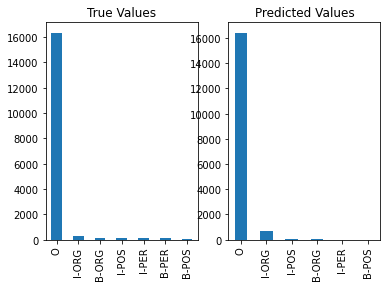

In [25]:
preds,valids = train_eval(model, training_loader)
print("Predicted Tag Counts")
print(pd.Series(preds).value_counts())
print("True Counts")
print(pd.Series(valids).value_counts())


fig, axes = plt.subplots(nrows=1, ncols=2)

pd.Series(valids).value_counts().plot(kind='bar', title = 'True Values', ax=axes[0])
pd.Series(preds).value_counts().plot(kind='bar', title = 'Predicted Values', ax=axes[1])

confusion_matrix([x.split('-')[1] if x != 'O' else x for x in valids], [x.split('-')[1] if x != 'O' else x for x in preds], labels = ['PER', 'POS', 'ORG', 'O'])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 1.3873932361602783
Validation Accuracy: 0.94703125
              precision    recall  f1-score   support

         ORG       0.00      0.00      0.00        14
         PER       0.00      0.00      0.00        16
         POS       0.00      0.00      0.00        18

   micro avg       0.00      0.00      0.00        48
   macro avg       0.00      0.00      0.00        48
weighted avg       0.00      0.00      0.00        48

Predicted Tag Counts
O        4339
I-ORG      51
I-POS      10
dtype: int64
True Counts
O        4263
I-ORG      35
I-POS      32
I-PER      22
B-POS      18
B-PER      16
B-ORG      14
dtype: int64


array([[   0,    0,    1,   37],
       [   0,    1,    1,   48],
       [   0,    0,    0,   49],
       [   0,    9,   49, 4205]])

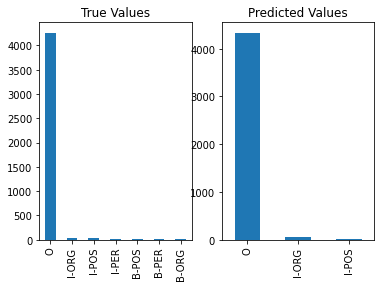

In [26]:
# To get the results on the validation set. This data is not seen by the model

preds, valids = test_eval(model, testing_loader)
print("Predicted Tag Counts")
print(pd.Series(preds).value_counts())
print("True Counts")
print(pd.Series(valids).value_counts())


fig, axes = plt.subplots(nrows=1, ncols=2)

pd.Series(valids).value_counts().plot(kind='bar', title = 'True Values', ax=axes[0])
pd.Series(preds).value_counts().plot(kind='bar', title = 'Predicted Values', ax=axes[1])

confusion_matrix([x.split('-')[1] if x != 'O' else x for x in valids], [x.split('-')[1] if x != 'O' else x for x in preds], labels = ['PER', 'POS', 'ORG', 'O'])

Visualize Confusion Matrix

In [27]:
!pip install sklearn_crfsuite

# BERT-BASE-UNCASED

In [28]:
# Defining some key variables that will be used later on in the training

MAX_LEN = max(slens)
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [29]:
#ALL sentences to lower

sentences = [s.lower() for s in sentences]

In [30]:
# Creating the dataset and dataloader for the neural network

train_percent = 0.8
train_size = int(train_percent*len(sentences))
# train_dataset=df.sample(frac=train_size,random_state=200).reset_index(drop=True)
# test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_sentences = sentences[0:train_size]
train_labels = labels[0:train_size]

test_sentences = sentences[train_size:]
test_labels = labels[train_size:]

print("FULL Dataset: {}".format(len(sentences)))
print("TRAIN Dataset: {}".format(len(train_sentences)))
print("TEST Dataset: {}".format(len(test_sentences)))

training_set = CustomDataset(tokenizer, train_sentences, train_labels, MAX_LEN)
testing_set = CustomDataset(tokenizer, test_sentences, test_labels, MAX_LEN)

FULL Dataset: 108
TRAIN Dataset: 86
TEST Dataset: 22


Create Dataloader for Inputs

In [31]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [32]:
len(vocab)

1490

## Train

### Create Network

In [33]:
class BERTUncasedClass(torch.nn.Module):
    def __init__(self):
        super(BERTUncasedClass, self).__init__()
        self.l1 = transformers.BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=7)
        # self.l2 = torch.nn.Dropout(0.3)
        # self.l3 = torch.nn.Linear(768, 200)
    
    def forward(self, ids, mask, labels):
        output_1= self.l1(ids, mask, labels = labels)
        # output_2 = self.l2(output_1[0])
        # output = self.l3(output_2)
        return output_1

In [34]:
uncased_model = BERTUncasedClass()
#model = BERT_CRF(tag2idx)
uncased_model.to(dev)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

BERTUncasedClass(
  (l1): BertForTokenClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)


In [35]:
optimizer = torch.optim.Adam(params =  uncased_model.parameters(), lr=LEARNING_RATE)

In [36]:
def train(epoch):
    uncased_model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(dev, dtype = torch.long)
        mask = data['mask'].to(dev, dtype = torch.long)
        targets = data['tags'].to(dev, dtype = torch.long)

        loss = uncased_model(ids, mask, labels = targets)[0]

        # optimizer.zero_grad()
        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [37]:
torch.cuda.empty_cache()

for epoch in range(5):
    train(epoch)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 0, Loss:  1.8711979389190674
Epoch: 1, Loss:  0.7893749475479126
Epoch: 2, Loss:  0.7285884022712708
Epoch: 3, Loss:  0.5398790836334229
Epoch: 4, Loss:  0.4804110825061798


In [38]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    flat_preds = np.argmax(preds, axis=2).flatten()
    flat_labels = labels.flatten()
    return np.sum(flat_preds == flat_labels)/len(flat_labels)

In [39]:
def test_eval(model, testing_loader):
    model.eval()
    eval_loss = 0; eval_accuracy = 0
    n_correct = 0; n_wrong = 0; total = 0
    predictions , true_labels = [], []
    nb_eval_steps, nb_eval_examples = 0, 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(dev, dtype = torch.long)
            mask = data['mask'].to(dev, dtype = torch.long)
            targets = data['tags'].to(dev, dtype = torch.long)

            output = model(ids, mask, labels=targets)
            loss, logits = output[:2]
            logits = logits.detach().cpu().numpy()
            label_ids = targets.to('cpu').numpy()
            predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
            true_labels.append(label_ids)
            accuracy = flat_accuracy(logits, label_ids)
            eval_loss += loss.mean().item()
            eval_accuracy += accuracy
            nb_eval_examples += ids.size(0)
            nb_eval_steps += 1
        eval_loss = eval_loss/nb_eval_steps
        print("Validation loss: {}".format(eval_loss))
        print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
        pred_tags = [tags_vals[p_i] for p in predictions for p_i in p]
        valid_tags = [tags_vals[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
        #print("F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
        print(classification_report_seqeval([valid_tags], [pred_tags]))
    return (pred_tags, valid_tags)

def train_eval(model, testing_loader):
    model.eval()
    eval_loss = 0; eval_accuracy = 0
    n_correct = 0; n_wrong = 0; total = 0
    predictions , true_labels = [], []
    nb_eval_steps, nb_eval_examples = 0, 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(dev, dtype = torch.long)
            mask = data['mask'].to(dev, dtype = torch.long)
            targets = data['tags'].to(dev, dtype = torch.long)

            output = model(ids, mask, labels=targets)
            loss, logits = output[:2]
            logits = logits.detach().cpu().numpy()
            label_ids = targets.to('cpu').numpy()
            predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
            true_labels.append(label_ids)
            accuracy = flat_accuracy(logits, label_ids)
            eval_loss += loss.mean().item()
            eval_accuracy += accuracy
            nb_eval_examples += ids.size(0)
            nb_eval_steps += 1
        eval_loss = eval_loss/nb_eval_steps
        print(pd.Series(predictions).value_counts())
        print("Training loss: {}".format(eval_loss))
        print("Training Accuracy: {}".format(eval_accuracy/nb_eval_steps))
        pred_tags = [tags_vals[p_i] for p in predictions for p_i in p]
        valid_tags = [tags_vals[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
        #print("F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
        print(classification_report_seqeval([valid_tags], [pred_tags]))
    return (pred_tags, valid_tags)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...]    71
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...]     1
[6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...]     1
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ORG       0.00      0.00      0.00       143
         PER       0.00      0.00      0.00        93
         POS       0.00      0.00      0.00        71

   micro avg       0.00      0.00      0.00       307
   macro avg       0.00      0.00      0.00       307
weighted avg       0.00      0.00      0.00       307

Predicted Tag Counts
O        16298
I-ORG      902
dtype: int64
True Counts
O        16355
I-ORG      311
B-ORG      142
I-POS      130
I-PER       98
B-PER       93
B-POS       71
dtype: int64


array([[    0,     0,    37,   154],
       [    0,     0,     3,   198],
       [    0,     0,   248,   205],
       [    0,     0,   614, 15741]])

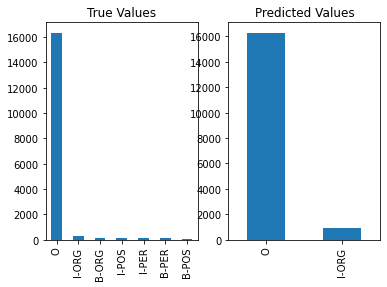

In [41]:
preds, valids = train_eval(uncased_model, training_loader)
print("Predicted Tag Counts")
print(pd.Series(preds).value_counts())
print("True Counts")
print(pd.Series(valids).value_counts())



#fig, axes = plt.subplots(nrows=1, ncols=2)

pd.Series(valids).value_counts().plot(kind='bar', title = 'True Values', ax=axes[0])
#pd.Series(preds).value_counts().plot(kind='bar', title = 'Predicted Values', ax=axes[1])

confusion_matrix([x.split('-')[1] if x != 'O' else x for x in valids], [x.split('-')[1] if x != 'O' else x for x in preds], labels = ['PER', 'POS', 'ORG', 'O'])

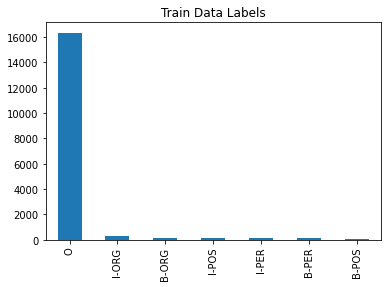

In [44]:
pd.Series(valids).value_counts().plot(kind='bar', title = 'Train Data Labels')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 1.614353358745575
Validation Accuracy: 0.95859375
              precision    recall  f1-score   support

         ORG       0.00      0.00      0.00        14
         PER       0.00      0.00      0.00        16
         POS       0.00      0.00      0.00        18

   micro avg       0.00      0.00      0.00        48
   macro avg       0.00      0.00      0.00        48
weighted avg       0.00      0.00      0.00        48

Predicted Tag Counts
O        4373
I-ORG      27
dtype: int64
True Counts
O        4263
I-ORG      35
I-POS      32
I-PER      22
B-POS      18
B-PER      16
B-ORG      14
dtype: int64


array([[   0,    0,    0,   38],
       [   0,    0,    2,   48],
       [   0,    0,    1,   48],
       [   0,    0,   24, 4239]])

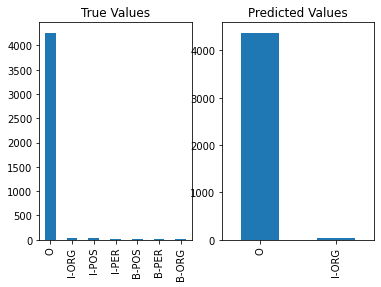

In [40]:
# To get the results on the validation set. This data is not seen by the model
from seqeval.metrics import classification_report as classification_report_seqeval

preds, valids = test_eval(uncased_model, testing_loader)
print("Predicted Tag Counts")
print(pd.Series(preds).value_counts())
print("True Counts")
print(pd.Series(valids).value_counts())


fig, axes = plt.subplots(nrows=1, ncols=2)

pd.Series(valids).value_counts().plot(kind='bar', title = 'True Values', ax=axes[0])
pd.Series(preds).value_counts().plot(kind='bar', title = 'Predicted Values', ax=axes[1])

confusion_matrix([x.split('-')[1] if x != 'O' else x for x in valids], [x.split('-')[1] if x != 'O' else x for x in preds], labels = ['PER', 'POS', 'ORG', 'O'])

### Test Eval

# Sources 

J. Hockenmaier, 2018. CS447: Natural Language Processing. *University of Illinois.* https://courses.engr.illinois.edu/cs447/fa2018/Slides/Lecture06.pdf


Data:
Leon Derczynski, Eric Nichols, Marieke van Erp, Nut Limsopatham; 2017. **Results of the WNUT2017 Shared Task on Novel and Emerging Entity Recognition**. In *Proceedings of the Workshop on Noisy, User-generated Text*, at EMNLP. https://github.com/leondz/emerging_entities_17